In [200]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import glob
import gc
import tensorflow as tf
from keras.layers import Conv1D, BatchNormalization, MaxPool1D, AveragePooling1D
from keras.layers import Dense, Flatten, Activation, Dropout
from keras.models import Sequential
from keras import optimizers
from xgboost import XGBRegressor
from tqdm import tqdm, trange
from sklearn.metrics import precision_recall_curve, auc
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
%matplotlib inline
# Any results you write to the current directory are saved as output.

In [156]:
base = '/kaggle/input/creditcardfraud/'
data = pd.read_csv(base+'creditcard.csv')
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [157]:
idx = np.arange(len(data))
np.random.seed(42)
ntest = int(0.2*len(data))
test_idx = np.random.randint(0, len(data), ntest)
train_idx = np.delete(idx, test_idx)
y = data['Class'][train_idx]
X = np.empty([len(y), 29, 1])
X[:, :, 0] = np.array(data.iloc[train_idx, 1:-1].copy())
X.shape

(233097, 29, 1)

In [174]:
filters = [2, 2, 2, 2, 1, 2]
strides = [1, 1, 1, 1]
pools = [2, 2, 2, 2, 1, 2]
channels = [4, 8, 16, 32, 64, 128]
activ_fn = 'tanh'
model = Sequential()

i = 3
model.add(Conv1D(channels[i], kernel_size = filters[i], padding = 'valid', input_shape = [29, 1]))
model.add(BatchNormalization(axis = -1))
model.add(Activation(activ_fn))
model.add(Conv1D(channels[i], kernel_size = filters[i], padding = 'valid'))
model.add(BatchNormalization(axis = -1))
model.add(Activation(activ_fn))
model.add(MaxPool1D(pool_size = pools[i]))
model.add(Dropout(0.25))

# for i in range(2, 3) : 
#     model.add(Conv1D(channels[i], kernel_size = filters[i], padding = 'valid'))
#     model.add(BatchNormalization(axis = -1))
#     model.add(Activation(activ_fn))
#     model.add(Conv1D(channels[i], kernel_size = filters[i], padding = 'valid'))
#     model.add(BatchNormalization(axis = -1))
#     model.add(Activation(activ_fn))
#     model.add(MaxPool1D(pool_size = pools[i]))
#     model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation(activ_fn))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

model.compile(loss = 'binary_crossentropy', 
              optimizer = optimizers.Adam(learning_rate = 0.003), 
              metrics = ['accuracy', tf.keras.metrics.AUC(curve = 'PR', name = 'auc_pr'), 
                         tf.keras.metrics.AUC(curve = 'ROC', name = 'auc_roc')])

Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_303 (Conv1D)          (None, 28, 32)            96        
_________________________________________________________________
batch_normalization_292 (Bat (None, 28, 32)            128       
_________________________________________________________________
activation_193 (Activation)  (None, 28, 32)            0         
_________________________________________________________________
conv1d_304 (Conv1D)          (None, 27, 32)            2080      
_________________________________________________________________
batch_normalization_293 (Bat (None, 27, 32)            128       
_________________________________________________________________
activation_194 (Activation)  (None, 27, 32)            0         
_________________________________________________________________
max_pooling1d_52 (MaxPooling (None, 13, 32)          

In [175]:
batch = 50
epoch = 10
model.fit(x = X, y = y, verbose = 1, batch_size = batch, epochs = epoch, validation_split = 0.2, shuffle = True)

Train on 186477 samples, validate on 46620 samples
Epoch 1/10
186477/186477 [==============================] - 31s 166us/step - loss: 0.0055 - accuracy: 0.9989 - auc_pr: 0.5144 - auc_roc: 0.8571 - val_loss: 0.0033 - val_accuracy: 0.9994 - val_auc_pr: 0.6249 - val_auc_roc: 0.8969
Epoch 2/10
186477/186477 [==============================] - 30s 159us/step - loss: 0.0041 - accuracy: 0.9992 - auc_pr: 0.6370 - auc_roc: 0.8985 - val_loss: 0.0038 - val_accuracy: 0.9992 - val_auc_pr: 0.6616 - val_auc_roc: 0.9074
Epoch 3/10
186477/186477 [==============================] - 31s 166us/step - loss: 0.0041 - accuracy: 0.9992 - auc_pr: 0.6678 - auc_roc: 0.9081 - val_loss: 0.0030 - val_accuracy: 0.9996 - val_auc_pr: 0.6815 - val_auc_roc: 0.9112
Epoch 4/10
186477/186477 [==============================] - 30s 162us/step - loss: 0.0041 - accuracy: 0.9993 - auc_pr: 0.6858 - auc_roc: 0.9114 - val_loss: 0.0032 - val_accuracy: 0.9995 - val_auc_pr: 0.6885 - val_auc_roc: 0.9118
Epoch 5/10
186477/186477 [=======

56961/56961 [==============================] - 2s 39us/step


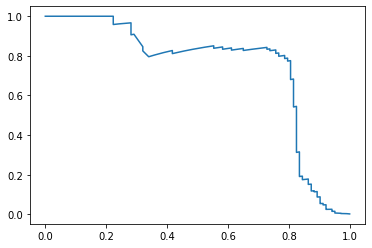

In [173]:
X_test = np.empty([len(test_idx), 29, 1])
X_test[:, :, 0] = np.array(data.iloc[test_idx, 1:-1].copy())
preds = model.predict(X_test, verbose = 1)
prec, rec, _ = precision_recall_curve(data['Class'][test_idx], preds)
plt.plot(rec, prec)

1. A network of Conv layers helps to push up the PR curve in high recall region, enabling higher precision for higher recall.
2. Tanh works much better for activation.

In [197]:
model2 = XGBRegressor(n_estimators = 100, learning_rate = 0.001, n_jobs = 5)
model2.fit(X[:, :, 0], y)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.001, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=5, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

auc_pr :  0.834428667435215


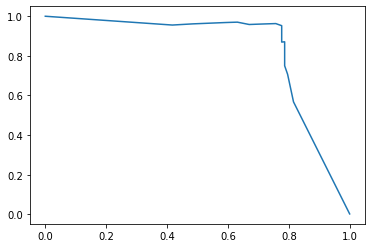

In [199]:
preds2 = model2.predict(X_test[:, :, 0])
prec, rec, _ = precision_recall_curve(data['Class'][test_idx], preds2)
plt.plot(rec, prec)
print('auc_pr : ', auc(rec, prec))

In [220]:
model3 = RandomForestClassifier(n_estimators = 49, n_jobs = 4)
model3.fit(X[:, :, 0], y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=49, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

auc_pr :  0.8695069568946695


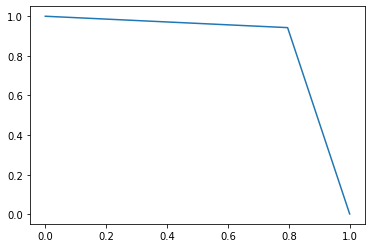

In [221]:
preds3 = model3.predict(X_test[:, :, 0])
prec, rec, _ = precision_recall_curve(data['Class'][test_idx], preds3)
plt.plot(rec, prec)
print('auc_pr : ', auc(rec, prec))